In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from scipy.stats import norm
from osgeo import gdal
import os
import time


In [2]:
class Dataset:
    def __init__(self, in_file):
        self.in_file = in_file  # Tiff或者ENVI文件

        dataset = gdal.Open(self.in_file)
        self.XSize = dataset.RasterXSize  # 网格的X轴像素数量
        self.YSize = dataset.RasterYSize  # 网格的Y轴像素数量
        self.Bands = dataset.RasterCount  # 波段数
        self.GeoTransform = dataset.GetGeoTransform()  # 投影转换信息
        self.ProjectionInfo = dataset.GetProjection()  # 投影信息
    
    def get_data(self):
        #band: 读取第几个通道的数据
        dataset = gdal.Open(self.in_file)
        data = dataset.ReadAsArray(0,0,self.XSize,self.YSize)
        return data
    

    def get_lon_lat(self):
        #获取经纬度信息
        gtf = self.GeoTransform
        x_range = range(0, self.XSize)
        y_range = range(0, self.YSize)
        x, y = np.meshgrid(x_range, y_range)
        lon = gtf[0] + x * gtf[1] + y * gtf[2]
        lat = gtf[3] + x * gtf[4] + y * gtf[5]
        
        lon_lat=[]
        for (longitude,latitude) in zip(lon,lat):
            lon_lat.append(list(zip(longitude,latitude)))
            
        return np.array(lon_lat)
    
    def new_dataset(self,data,lon_lat):
        new_dataset=[]
        for i in range(self.YSize):
            for j in range(self.XSize):
                x1 = lon_lat[i,j,:]
                x2 = data[i,j,:]
                x=np.hstack((x1,x2))
                new_dataset.append(x)
            
        return np.array(new_dataset)

In [3]:
def Doublelogic(x, m1, m2, m3, m4, m5, m6):
    return m1 + m2 /(1 + np.exp(-m3 * (x-m4))) - m2/(1 + np.exp(-m5 * (x-m6)))

#注意初值
def fitting(yData, xData) :
    Parameters, pcov = curve_fit(Doublelogic, xData, yData, p0=[5,40,0.1,140,0.1,270], maxfev=10000000)#,method='trf', maxfev=1000000)
    return Parameters

def for_map(yData, xData):
    result=np.array(list(map(fitting,yData,xData)))
 
    return result

In [4]:
dir_path = r"D:\Desktop\mypaper\data"
filename = "gee-LAI-108.tif"
file_path = os.path.join(dir_path, filename)
dataset = Dataset(file_path)
data = dataset.get_data( ).transpose(1,2,0) 
xdim=data.shape[0]
ydim=data.shape[1]
zdim=data.shape[2]
xInput=np.linspace(1, 361, 92)
xData=np.repeat([np.repeat([xInput],ydim,axis=0)],xdim,axis=0)
result=np.array(list(map(for_map,data,xData)))

d:\python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [5]:
m1, m2, m3, m4, m5, m6=result[0,0,:]
fitting=Doublelogic(xInput,m1, m2, m3, m4, m5, m6)
error=data[0,0,:]-fitting

Text(0.5, 0, 'Length')

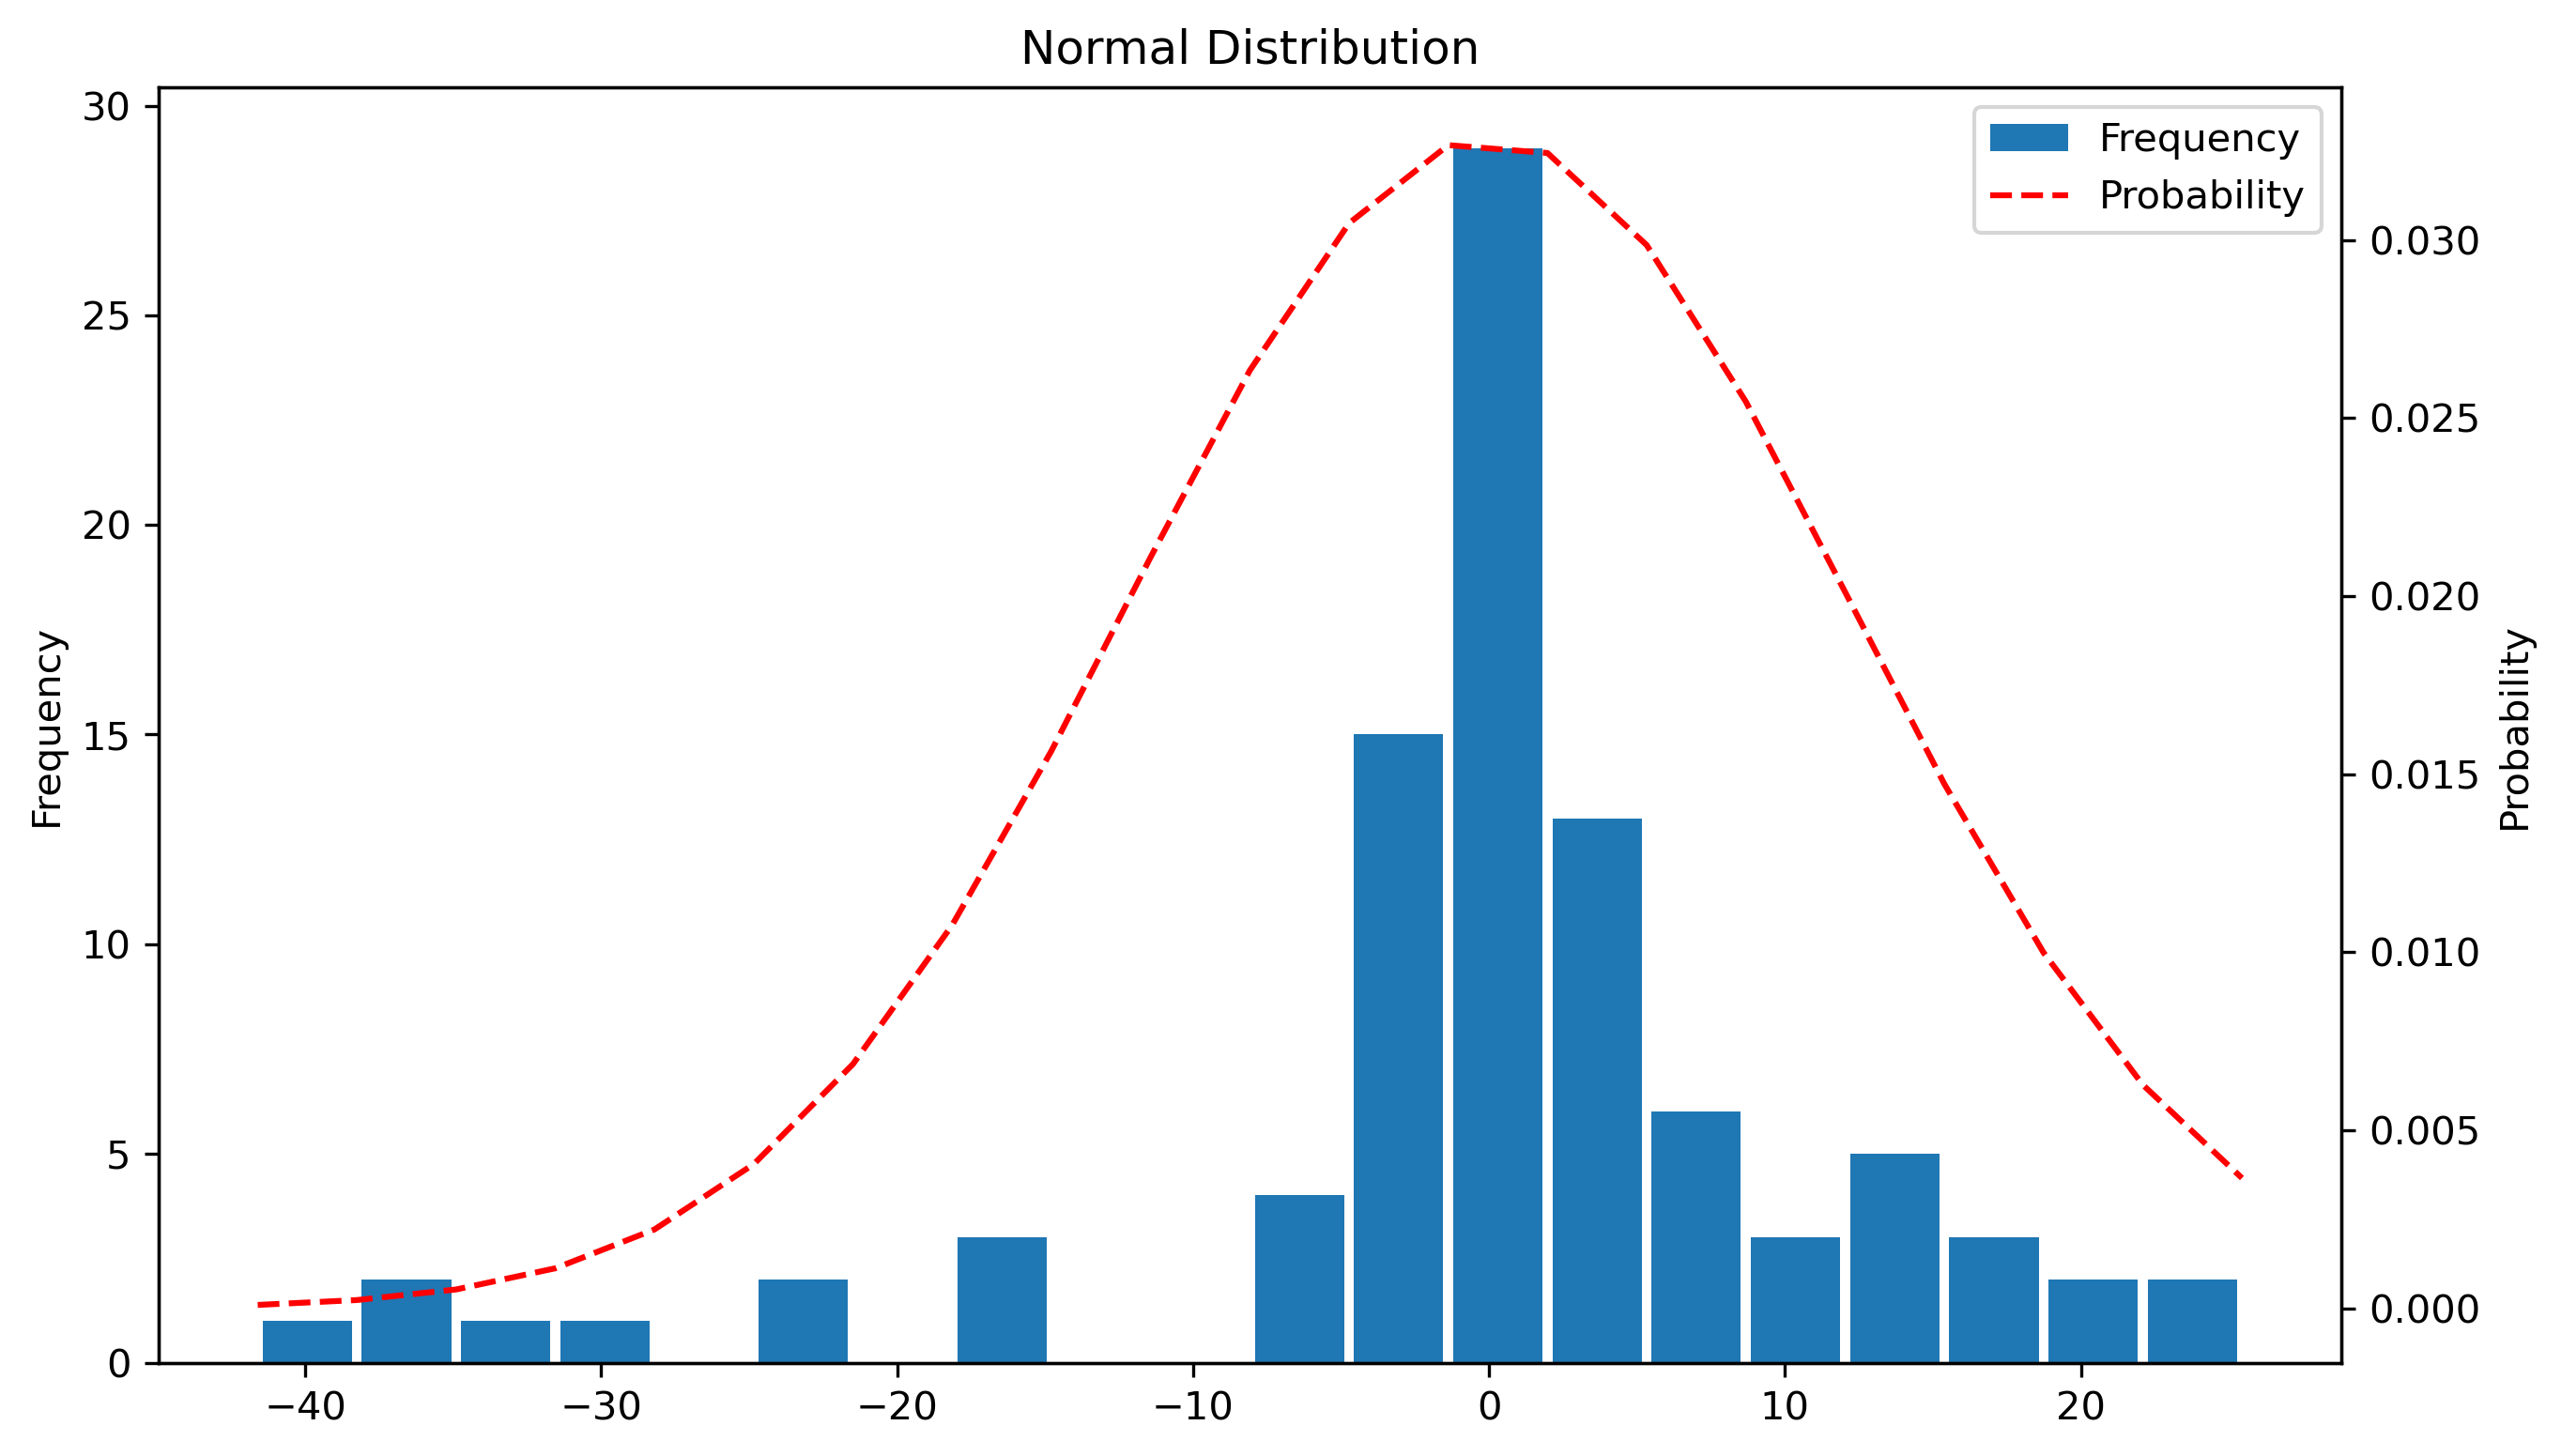

In [6]:
mu  = error.mean() # 获得数据集的平均值
sigma  = error.std()   # 获得数据集的标准差
fig = plt.figure(figsize=(10,6),dpi=300)
ax1 = fig.subplots()
ax1.set_ylabel('Frequency')
n, bins, patches = ax1.hist(error, bins=20,rwidth=0.9,label='Frequency')#, density=True

ax2 = ax1.twinx()
ax2.set_ylabel('Probability')
y = norm.pdf(bins, mu, sigma)#拟合一条最佳正态分布曲线y norm.pdf
plt.plot(bins, y, 'r--',label='Probability') #绘制y的曲线 

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)


plt.title('Normal Distribution')
plt.xlabel('Length')
# plt.savefig('D:/Desktop/Normal-Distribution.jpg',bbox_inches='tight',pad_inches=0.1)

In [7]:
def get_range(data,minX,maxX):
    if data <= maxX and data >= minX:
        return data
    
def get_data_percent(data,perc_low,perc_high):
    perc_low_data=np.percentile(data, perc_low, interpolation='higher')
    perc_high_data=np.percentile(data, perc_high, interpolation='higher')
    minX=np.repeat([perc_low_data],data.size,axis=0)
    maxX=np.repeat([perc_high_data],data.size,axis=0)
    error1=list(map(get_range,data,minX,maxX))
    error2 = list(filter(None,error1))
    return np.array(error2)

Text(0.5, 0, 'Length')

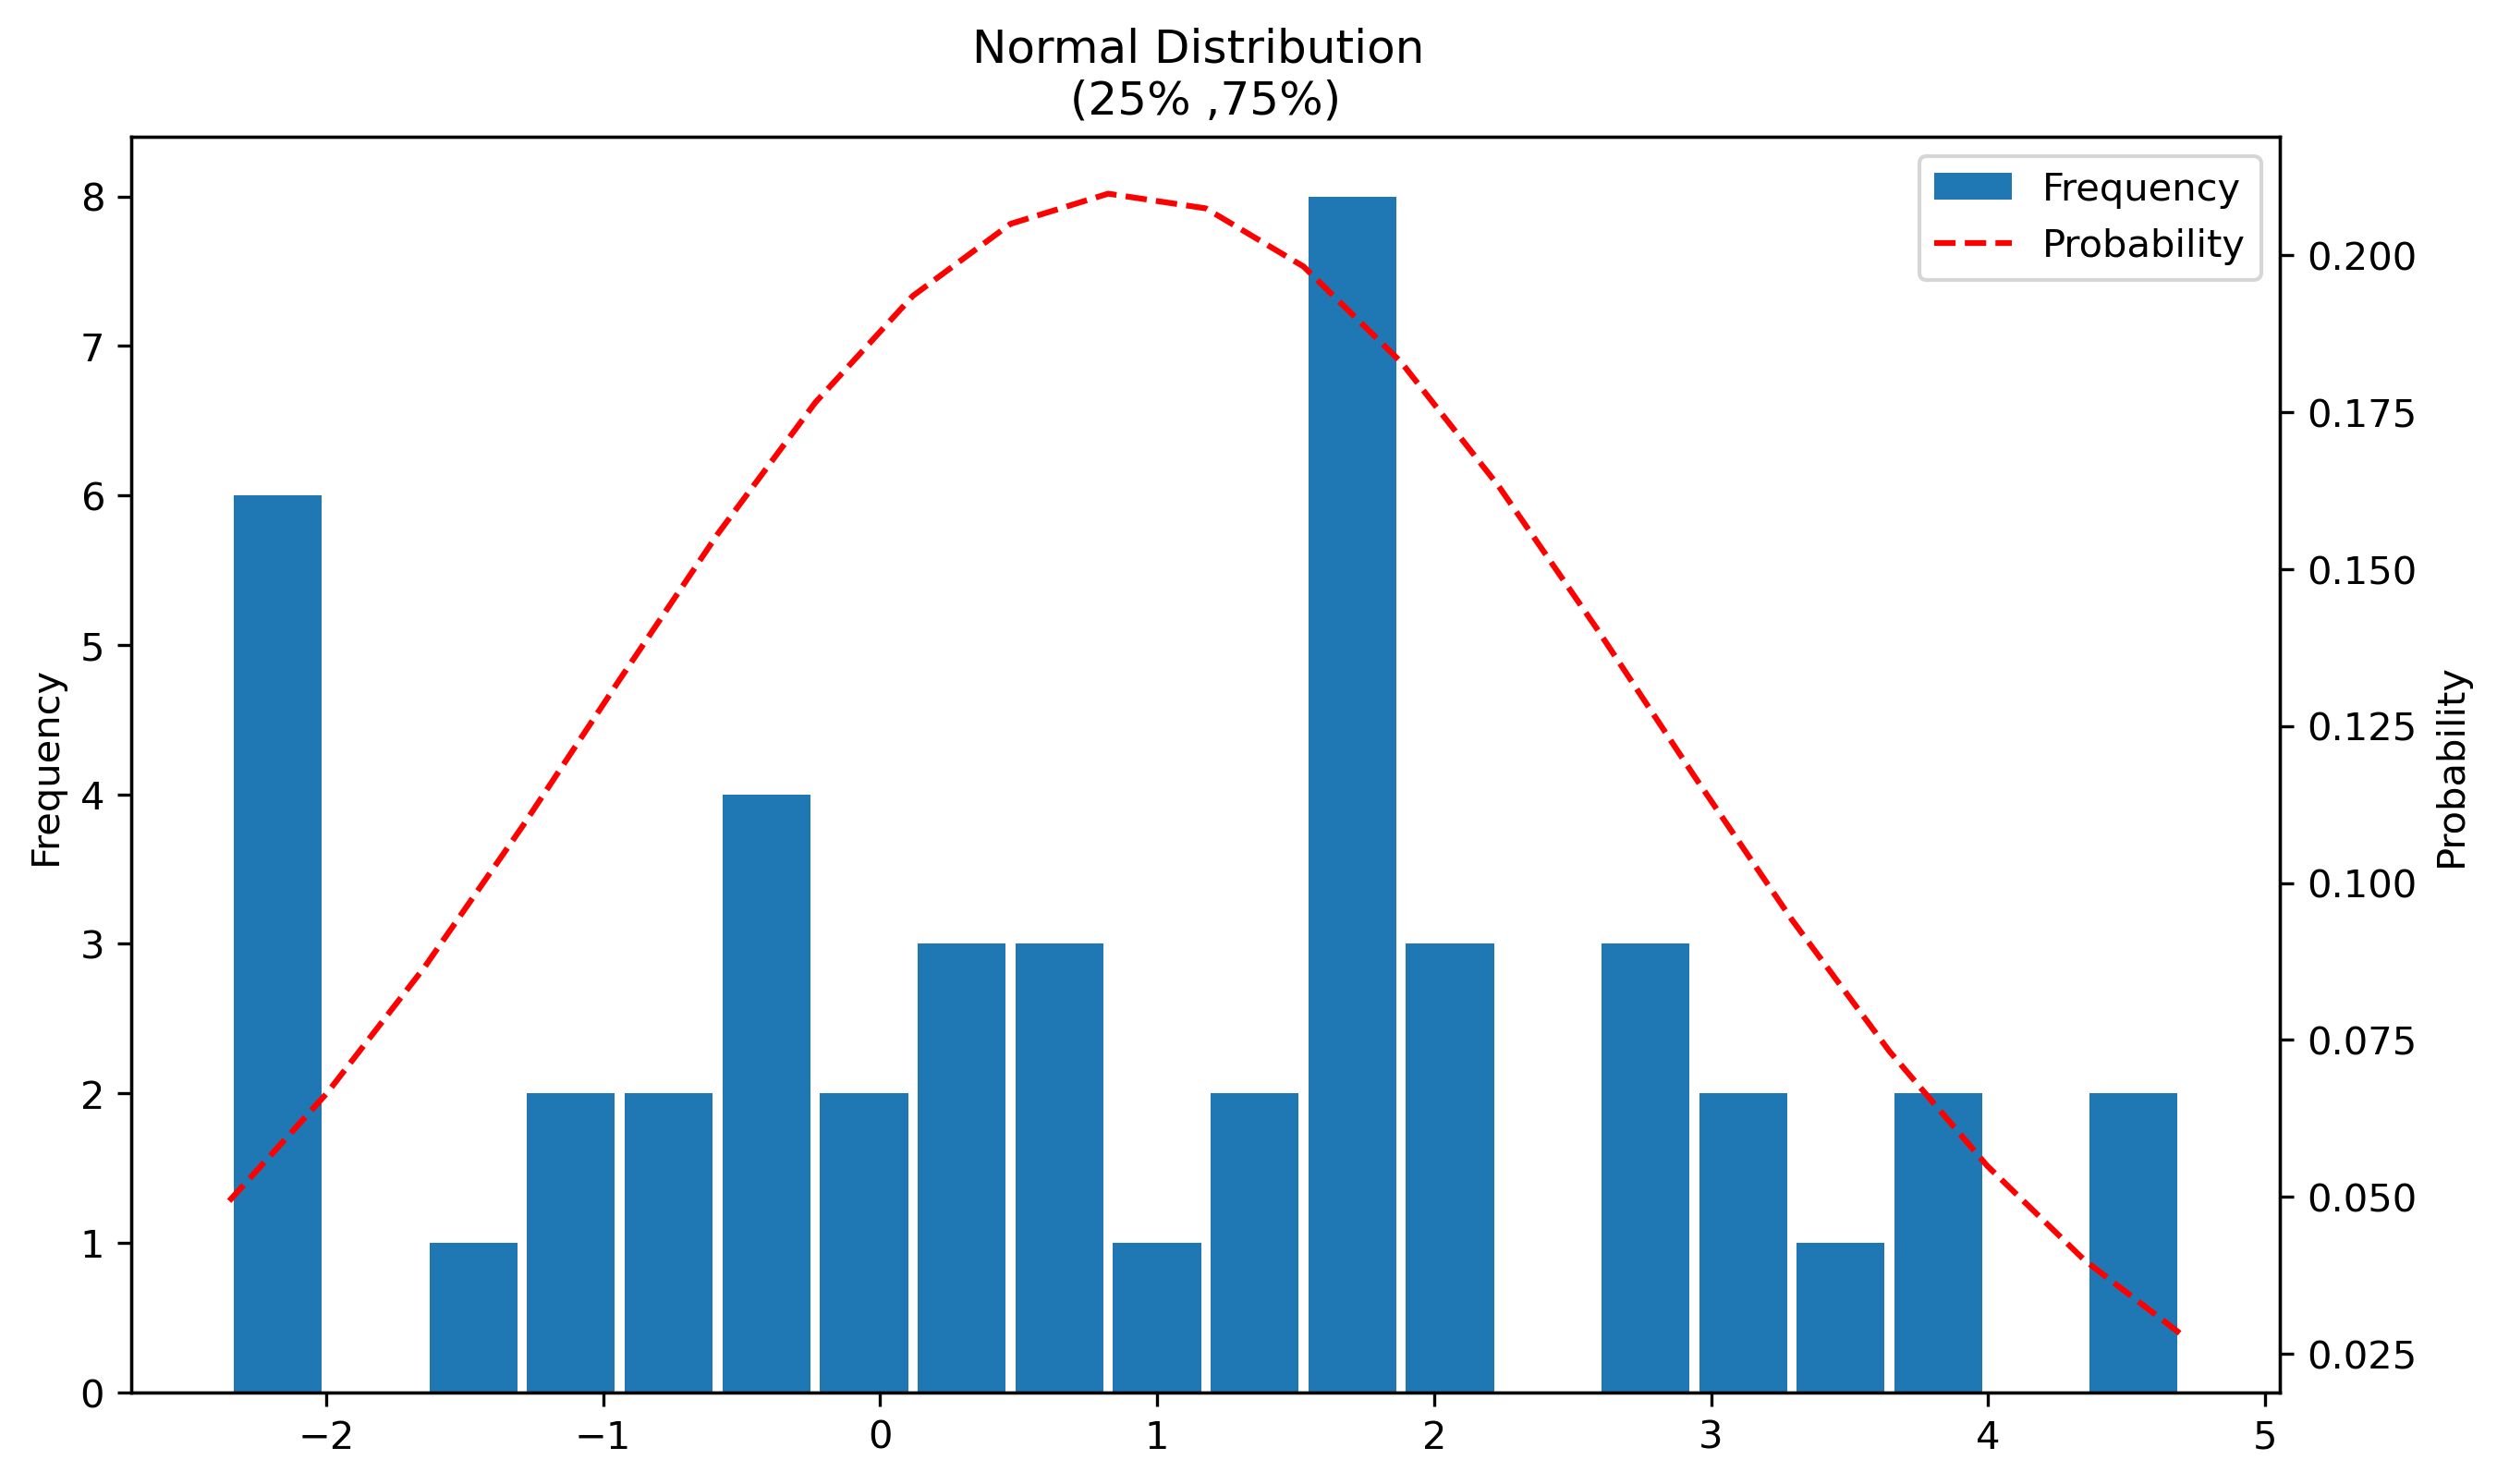

In [8]:
error1=get_data_percent(error,25,75)
mu  = error1.mean() # 获得数据集的平均值
sigma  = error1.std()   # 获得数据集的标准差
fig = plt.figure(figsize=(10,6),dpi=300)
ax1 = fig.subplots()
ax1.set_ylabel('Frequency')
n, bins, patches = ax1.hist(error1, bins=20,rwidth=0.9,label='Frequency')#, density=True

ax2 = ax1.twinx()
ax2.set_ylabel('Probability')
y = norm.pdf(bins, mu, sigma)#拟合一条最佳正态分布曲线y norm.pdf
plt.plot(bins, y, 'r--',label='Probability') #绘制y的曲线 

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)


plt.title('Normal Distribution \n(25% ,75%)')
plt.xlabel('Length')
# plt.savefig('D:/Desktop/Normal-Distribution.jpg',bbox_inches='tight',pad_inches=0.1)

In [9]:
def get_data_percent_box(data,perc_low,perc_high):
    perc_low_data=np.percentile(data, perc_low, interpolation='higher')
    perc_high_data=np.percentile(data, perc_high, interpolation='higher')
   
    minXInput=perc_low_data-1.5*(perc_high_data-perc_low_data)
    maxXInput=perc_high_data+1.5*(perc_high_data-perc_low_data)

    minX=np.repeat([minXInput],data.size,axis=0)
    maxX=np.repeat([maxXInput],data.size,axis=0)
    
    error1=list(map(get_range,data,minX,maxX))
    error2 = list(filter(None,error1))
    return np.array(error2)

Text(0.5, 0, 'Length')

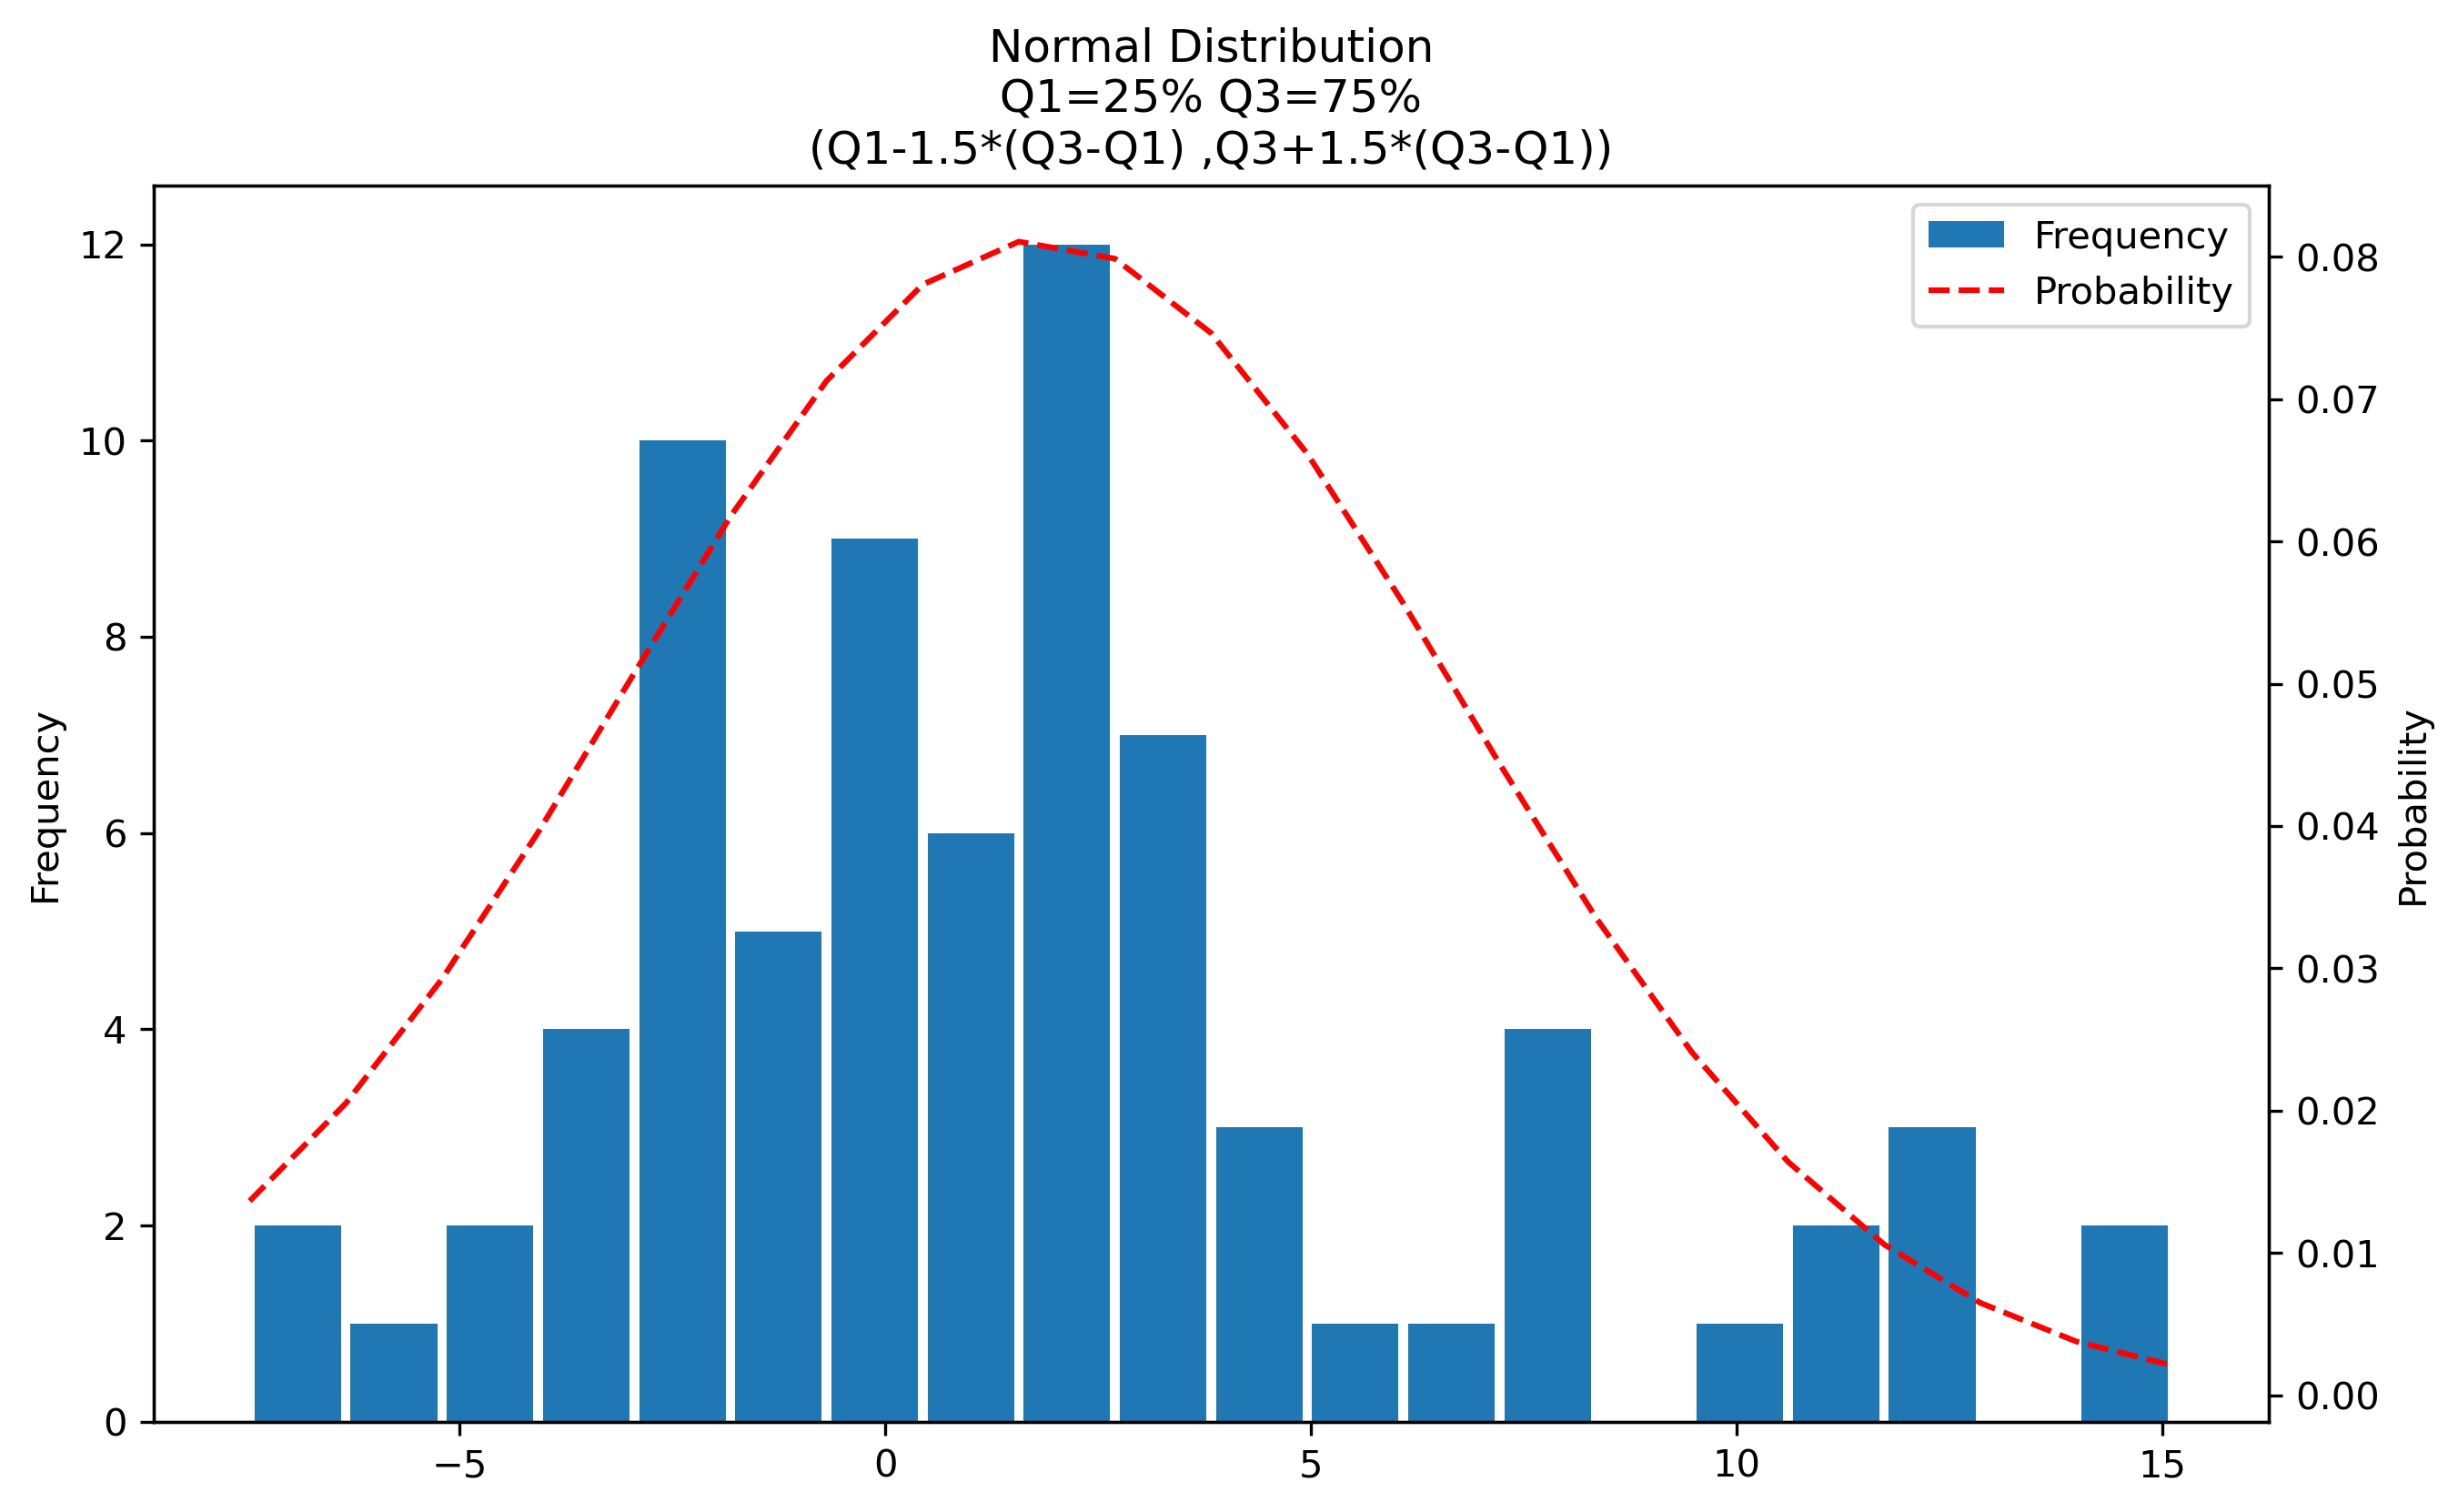

In [10]:
error2=get_data_percent_box(error,25,75)
mu  = error2.mean() # 获得数据集的平均值
sigma  = error2.std()   # 获得数据集的标准差
fig = plt.figure(figsize=(10,6),dpi=300)
ax1 = fig.subplots()
ax1.set_ylabel('Frequency')
n, bins, patches = ax1.hist(error2, bins=20,rwidth=0.9,label='Frequency')#, density=True

ax2 = ax1.twinx()
ax2.set_ylabel('Probability')
y = norm.pdf(bins, mu, sigma)#拟合一条最佳正态分布曲线y norm.pdf
plt.plot(bins, y, 'r--',label='Probability') #绘制y的曲线 

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

t=75
plt.title('Normal Distribution\n Q1=25% Q3=75% \n(Q1-1.5*(Q3-Q1) ,Q3+1.5*(Q3-Q1))')
plt.xlabel('Length')
# plt.savefig('D:/Desktop/Normal-Distribution-65%.jpg',bbox_inches='tight',pad_inches=0.1)

In [11]:
from outliers import smirnov_grubbs as grubbs

Text(0.5, 0, 'Length')

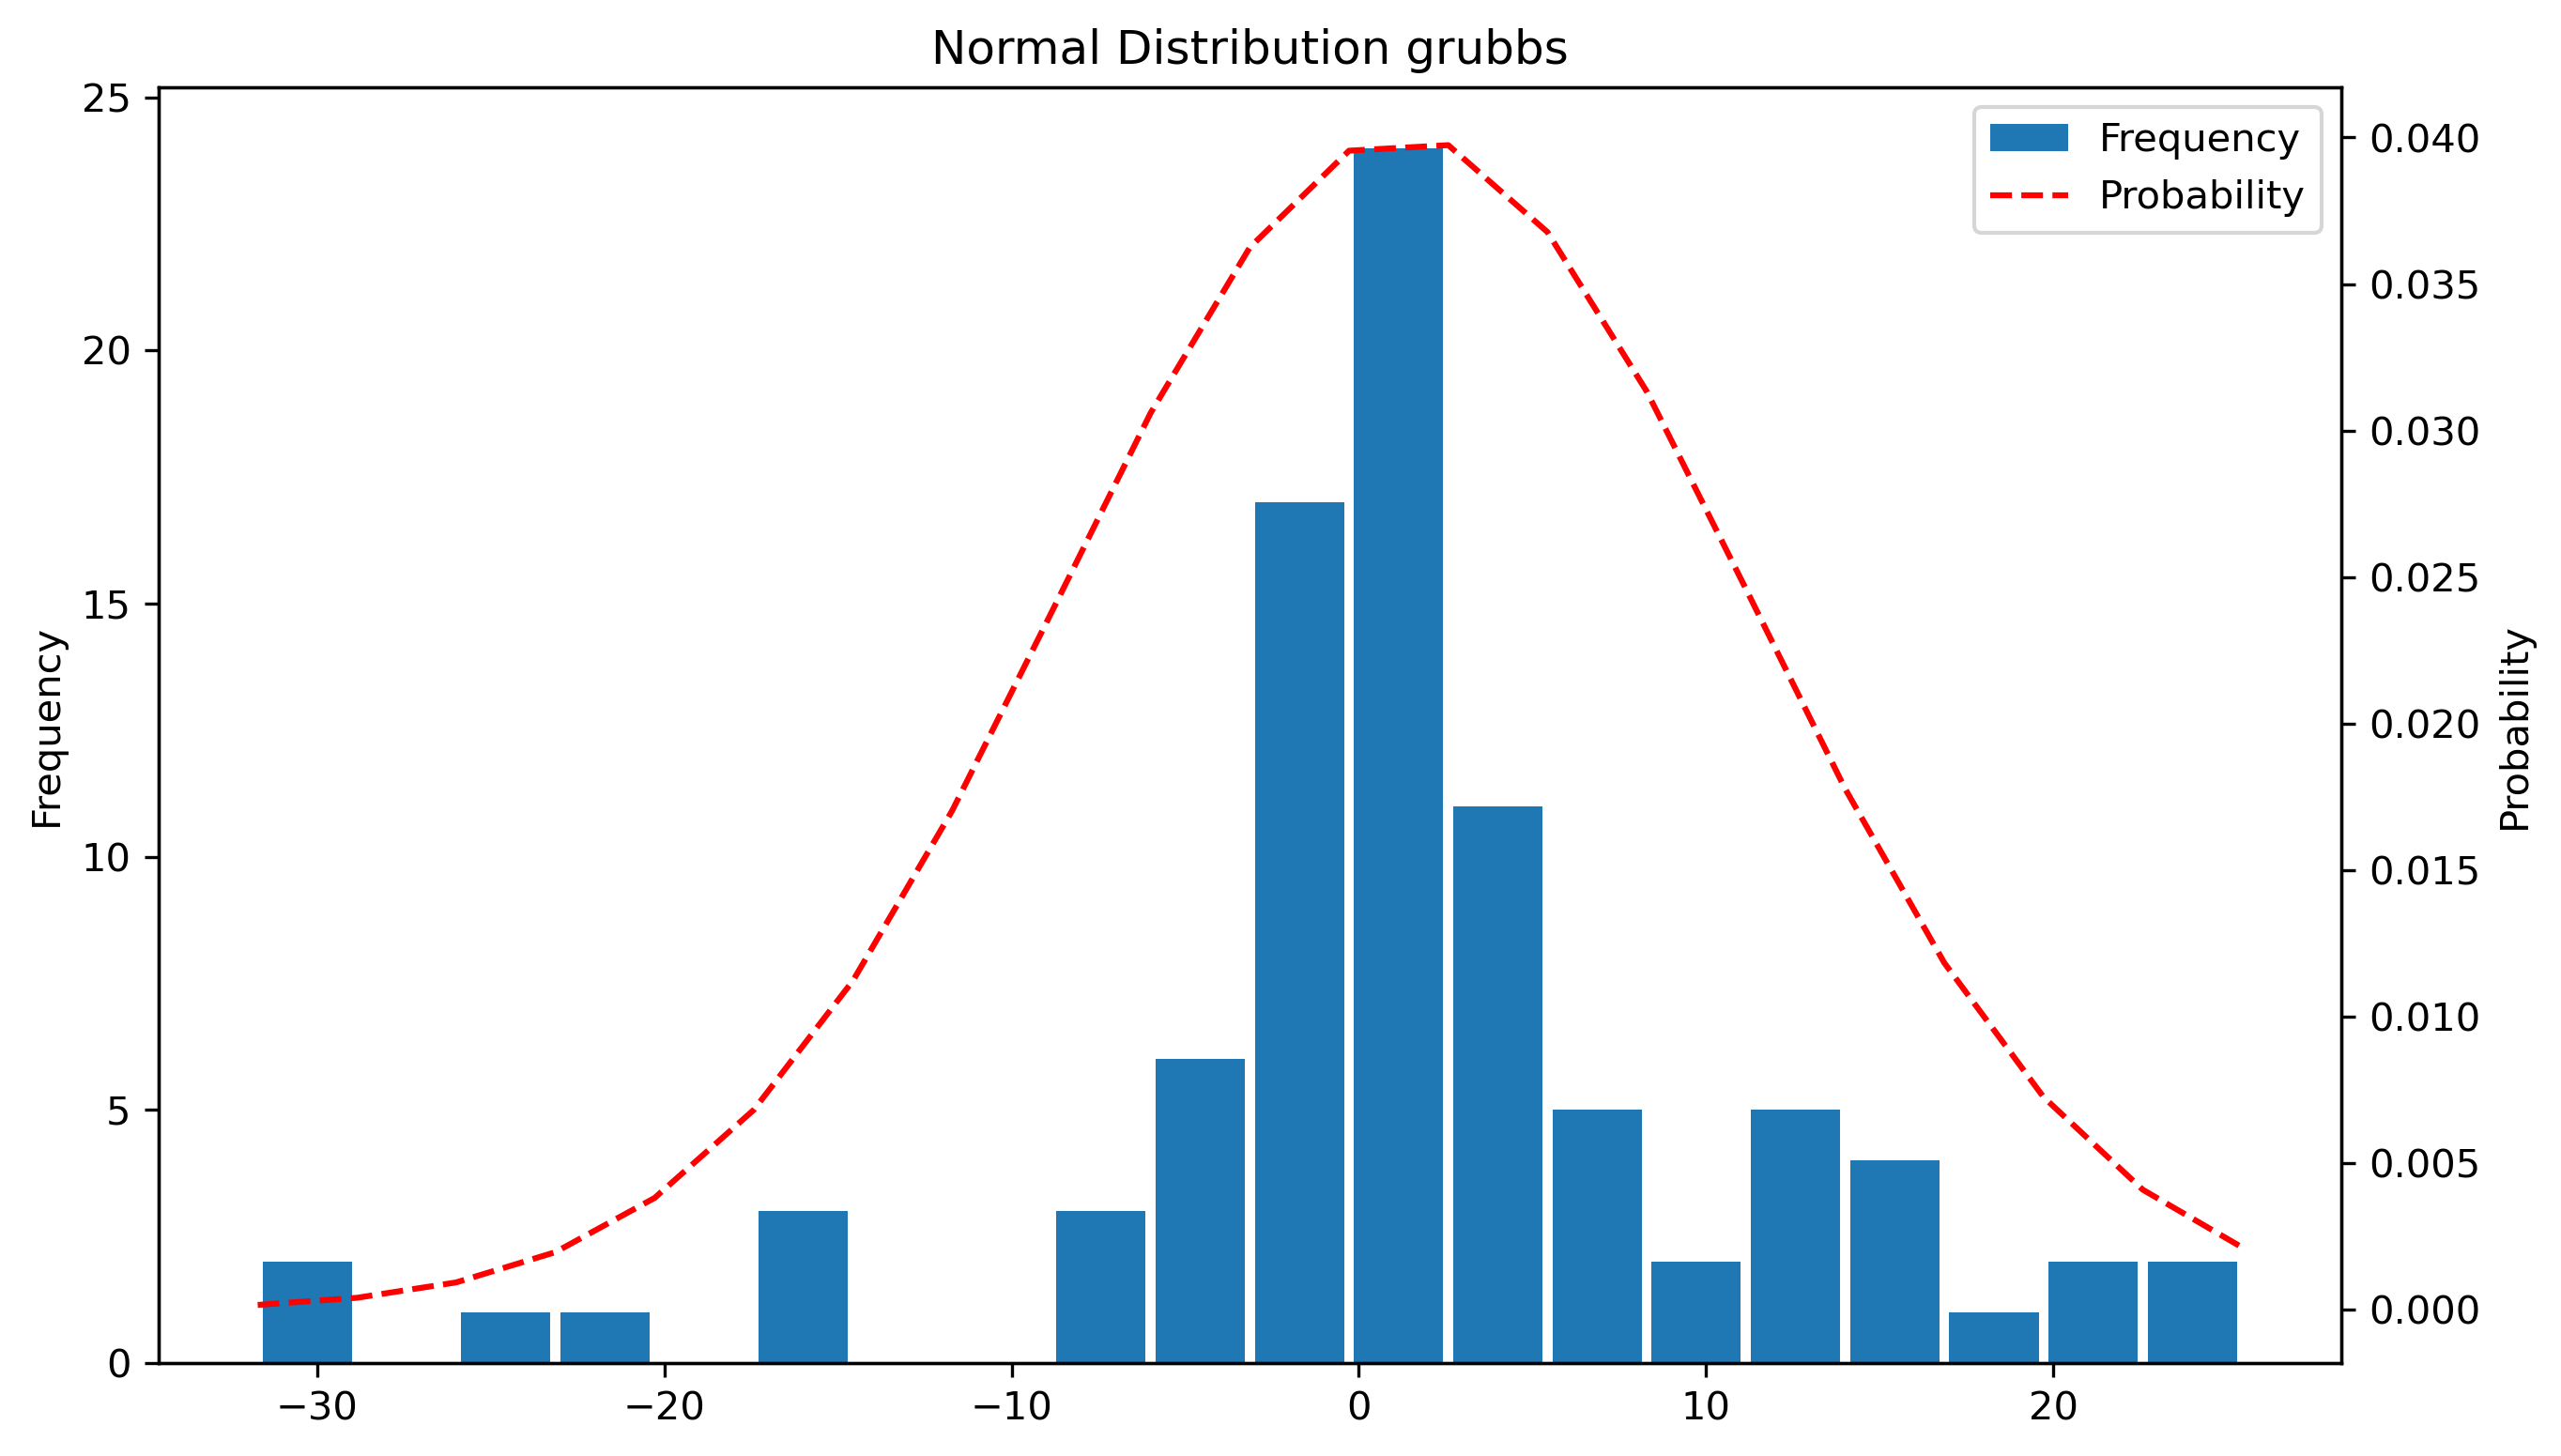

In [12]:
error3=grubbs.test(error, alpha=0.05)
mu  = error3.mean() # 获得数据集的平均值
sigma  = error3.std()   # 获得数据集的标准差
fig = plt.figure(figsize=(10,6),dpi=300)
ax1 = fig.subplots()
ax1.set_ylabel('Frequency')
n, bins, patches = ax1.hist(error3, bins=20,rwidth=0.9,label='Frequency')#, density=True

ax2 = ax1.twinx()
ax2.set_ylabel('Probability')
y = norm.pdf(bins, mu, sigma)#拟合一条最佳正态分布曲线y norm.pdf
plt.plot(bins, y, 'r--',label='Probability') #绘制y的曲线 

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

t=75
plt.title('Normal Distribution grubbs')
plt.xlabel('Length')
# plt.savefig('D:/Desktop/Normal-Distribution-65%.jpg',bbox_inches='tight',pad_inches=0.1)